# Exercises

### Code for data generation

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import poisson, pearsonr
from matplotlib import rcParams

plt.rcParams['figure.figsize'] = [10, 5]


In [15]:
## some helper functions to simulate and decode data

            
def simulate_data(noise_firing_rate = 0.1, save_file = False, out_path = 'linear_track_data.pickle'):

    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = 5 # the peak firing rate, averaged across the population 
    n_cells = 100 # how many cells we are recording
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

    # GENERATE TRAJECTORY

    n_runs = 20
    use_stops = False
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 10 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])

    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        if use_stops:
            x = np.concatenate((x, stop1, run1, stop2, run2))
        else:
            x = np.concatenate((x, run1, run2))
    t = np.arange(len(x))/fps

    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    out_data = {}
    out_data['x'] = x
    out_data['t'] = t
    out_data['spikes'] = spikes
    out_data['track_length'] = track_length
    out_data['fps'] = fps

    if save_file:
        with open('data/'+out_path,'wb') as f:
            pickle.dump(out_data,f)

    return out_data

def preprocess(data, proportion_cells = 1):
    x,t,spikes = data['x'],data['t'],data['spikes']
    track_length = data['track_length']
    fps = data['fps'] 
    n_cells = len(spikes)

    n_cells = int(n_cells * proportion_cells)
    spikes = spikes[:n_cells]

    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape
    
    return x, t, fps, n_cells, firing_rate_maps, spikes_count, space_bins

def decode(data, proportion_samples = 1, proportion_cells = 1, prior = None, loop = False, log_poisson = False):

    x, t, fps, n_cells, firing_rate_maps, spikes_count, space_bins = preprocess(data, proportion_cells = proportion_cells)

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes

    n_samples = int(len(true_x)*proportion_samples)
    
    spikes_count = spikes_count[:n_samples]
    true_x = true_x[:n_samples]

    epsilon = pow(1,-10)

    if loop:
        # get rid of last timepoint to have same length as binned spikes
        decoding_times = t[:-1]
        decoding_times = decoding_times[:n_samples]

        x_decoded = np.zeros_like(true_x)

        for t_bin in tqdm(range(len(decoding_times))):
            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
                posterior = np.empty(firing_rate_maps.shape[-1])

                for i in range(len(posterior)):
                    # Note that we work with log so that we can sum probabilities
                    # instead of multiplying them 
                    if log_poisson:
                        posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                    else:
                        posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]
            else:
                x_decoded[t_bin] = np.nan   
        
    else:
        log_posteriors = spikes_count @ np.log(firing_rate_maps+epsilon) - (1./fps)*np.sum(firing_rate_maps, axis=0) #+ np.log(prior + epsilon)
        x_parallel = [space_bins[np.argmax(P)] for P in log_posteriors]
        x_decoded = x_parallel
    
    median_error = np.nanmedian(np.abs(x_decoded - true_x))

    return n_samples, n_cells, median_error, true_x, x_decoded

def simulate_sequential_reactivation_data(firing_rate_maps, n_cells, n_events, noise_x_react = 5, noise_t_react = 5, n_true_events = 100):

    event_duration = 100 # in bins
    sampling_rate = 100 # sampling rate 
    t_react = np.arange(0,100)
    noise_firing_rate = 0.1 # the baseline noise firing rate
    track_length = 200 # the length of the track

    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))

    for event in range(n_events):
        if(event<n_true_events):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,noise_x_react,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration)

        x_react[x_react<0]=0
        x_react[x_react>track_length]=track_length
        
        #store reactivation sequence
        reactivation_events[event,:] = x_react

        
        # Generate spikes according to the location being reactivated in this event
        
        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1


    time_window = 10 # number of bins to aggregate during decoding

    reactivation_slope = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        # First we bin the events in windows of 10 bins
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

    return spikes_react

def decode_sequential_reactivation(spikes_react, n_events, n_cells, firing_rate_maps, space_bins, fps, spikes_count):
    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)

        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
            reactivation_pvalues[event] = corr[1]
    
    return reactivation_pvalues


In [16]:
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

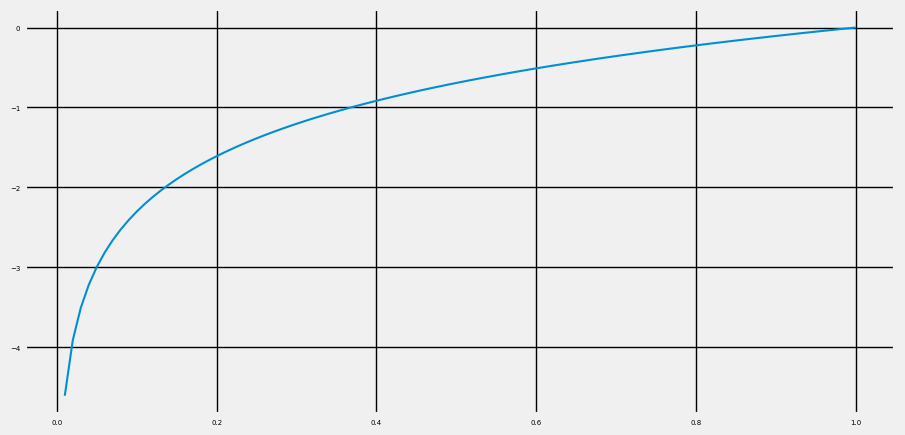

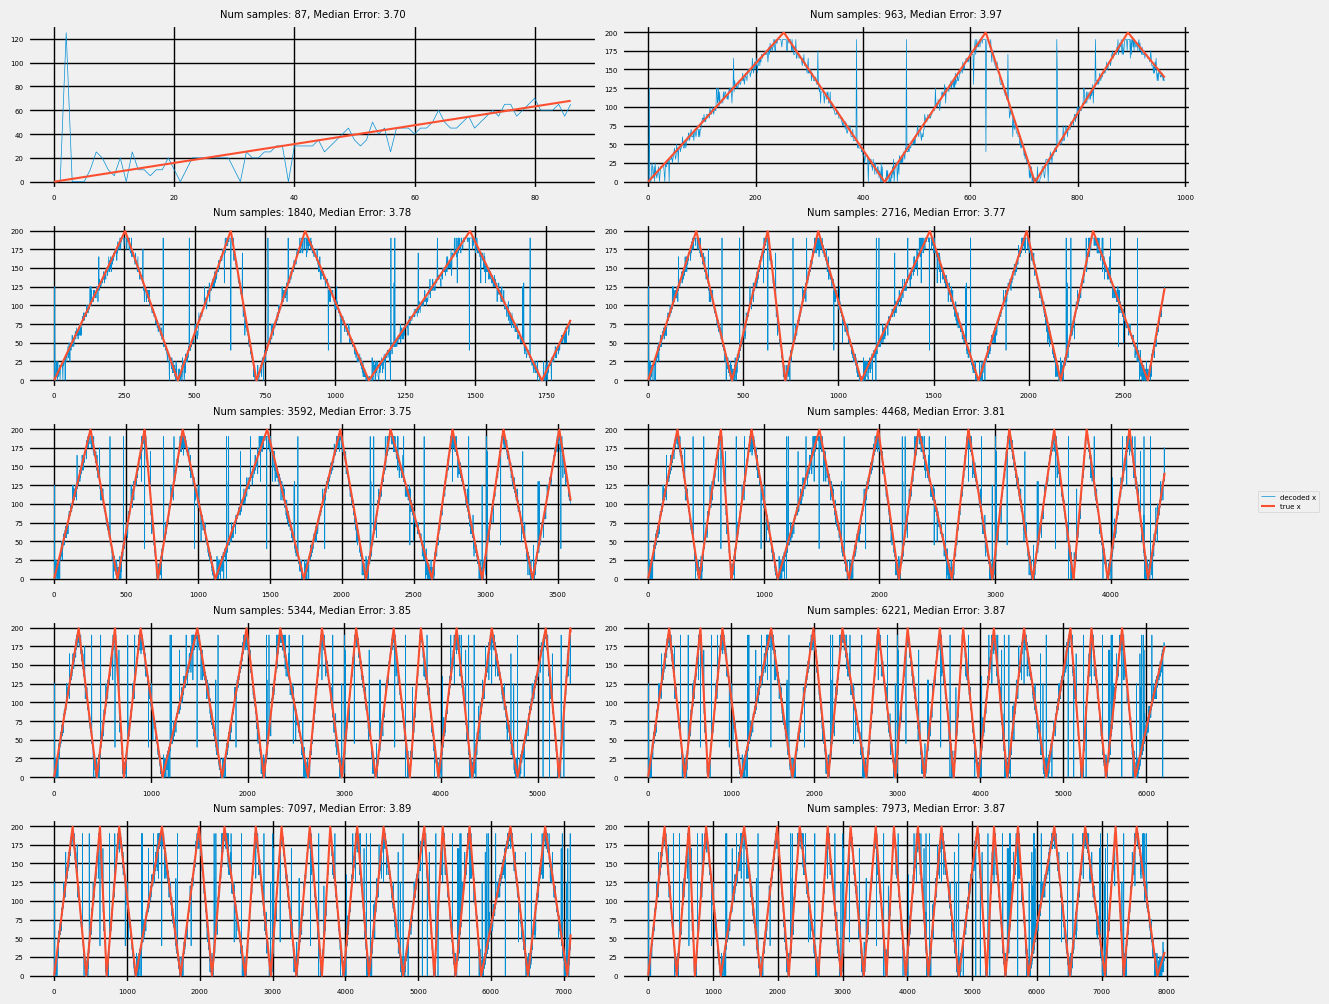

In [17]:
sample_proportions = np.linspace(0.01, 1, 100)

plt.plot(sample_proportions, np.log(sample_proportions))
plt.show()

fig, axes = plt.subplots(int(len(sample_proportions)/10//2), 2, figsize=(12, 10))

median_errors = np.empty(len(sample_proportions))
number_samples = np.empty(len(sample_proportions))

idx = 0

for i, proportion_samples in enumerate(sample_proportions):
    n_samples, _, median_error, true_x, x_parallel = decode(data, proportion_samples = proportion_samples)

    if i%10 == 0:      
        ax = axes[idx//2, idx%2]
        ax.set_title(f'Num samples: {n_samples}, Median Error: {median_error:.2f}')
        ax.plot(x_parallel,label= 'decoded x', lw = 0.5)
        ax.plot(true_x,label = 'true x')
        idx += 1

    median_errors[i], number_samples[i] = median_error, n_samples

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.show()

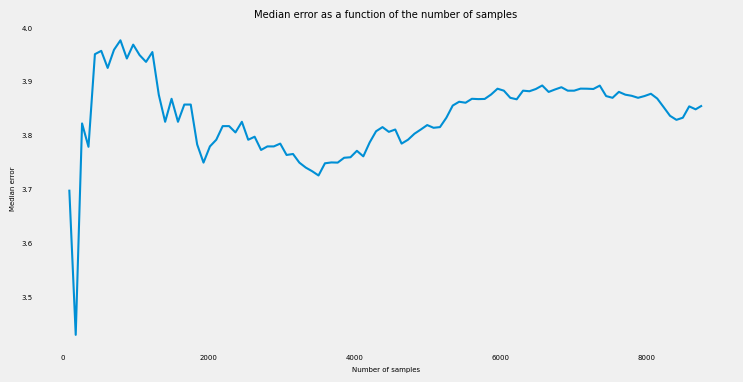

In [18]:
plt.figure(figsize=(8,4))
plt.plot(number_samples, median_errors)
plt.title('Median error as a function of the number of samples')
plt.xlabel('Number of samples')
plt.ylabel('Median error')
plt.grid()
plt.show()

(A) For a small number of samples the median error is smaller but then grows fast and converges to about 3.9. This is due to the fact that the animal does not explore the full track for a small number of samples. Once the full track is explored, the median error stays more or less constant.

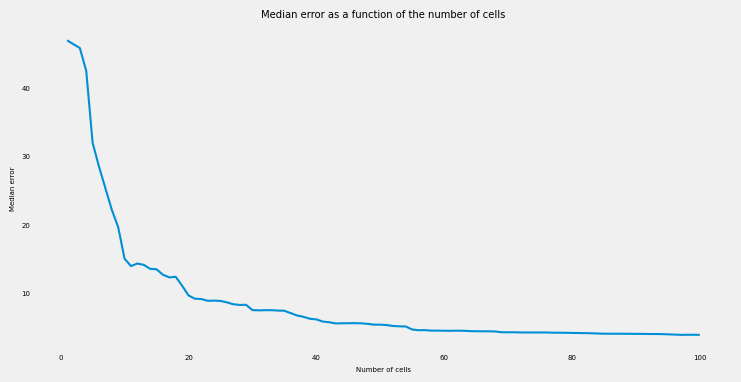

In [19]:
cells_proportions = np.linspace(0.01, 1, 100)

median_errors = np.empty(len(sample_proportions))
number_cells = np.empty(len(sample_proportions))

for i, proportion_cells in enumerate(cells_proportions):
    _, n_cells, median_error, true_x, x_parallel = decode(data, proportion_cells = proportion_cells)
    median_errors[i], number_cells[i] = median_error, n_cells 

plt.figure(figsize=(8,4))
plt.plot(number_cells, median_errors)
plt.title('Median error as a function of the number of cells')
plt.xlabel('Number of cells')
plt.ylabel('Median error')
plt.grid()
plt.show()


(B) The more cells, the lower the error. However, the median error seems to start converging at about 60 cells. This is due to the fact that more cells give more information about the system. 

10it [06:20, 38.03s/it]


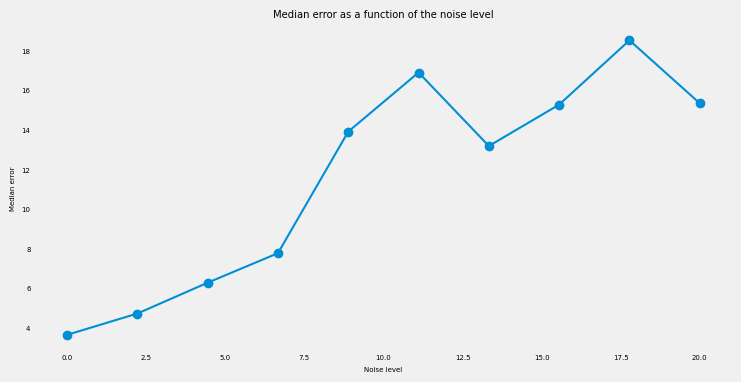

In [20]:
noise_levels = np.linspace(0., 20, 10)

median_errors = np.empty(len(noise_levels))

for i, noise_firing_rate in tqdm(enumerate(noise_levels)):
    data = simulate_data(noise_firing_rate = noise_firing_rate)
    _, _, median_error, _, _ = decode(data)
    median_errors[i] = median_error

plt.figure(figsize=(8,4))
plt.plot(noise_levels, median_errors, 'o-')
plt.title('Median error as a function of the noise level')
plt.xlabel('Noise level')
plt.ylabel('Median error')
plt.grid()
plt.show()

(C) As is to be expected, the Median error increases as the noise increases. The relationship seems more or less linear.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




In [21]:
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

100%|██████████| 8762/8762 [00:31<00:00, 282.63it/s]


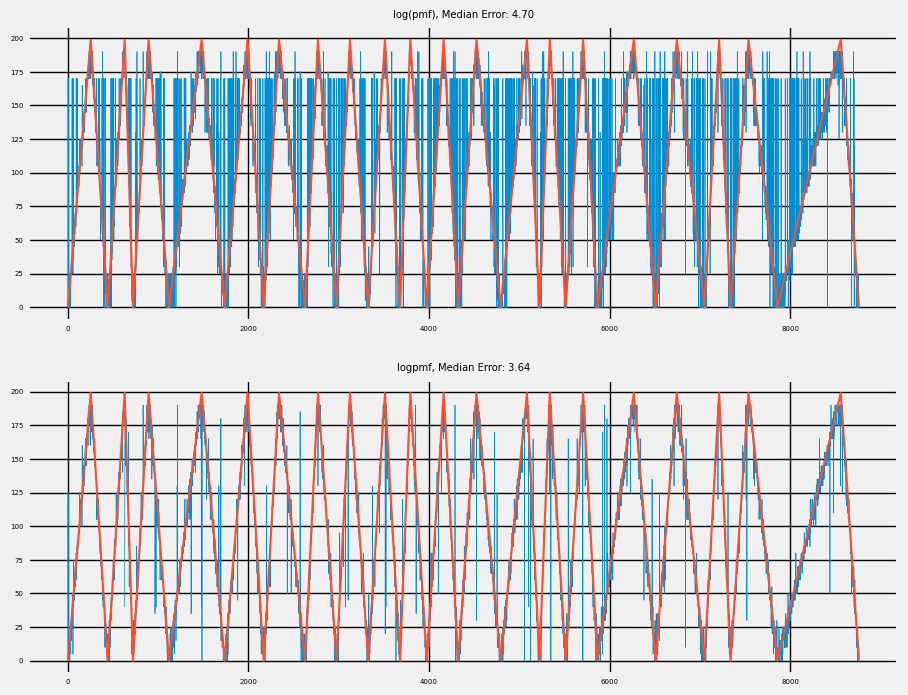

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

modes = {"log(pmf)": True, "logpmf": False}

for i, (mode, log_poisson) in enumerate(modes.items()):
    _, _, median_error, true_x, x_decoded = decode(data, loop = True, log_poisson=log_poisson)

    axes[i].plot(x_decoded,label= 'decoded x', lw = 0.5)
    axes[i].plot(true_x,label = 'true x')
    axes[i].set_title(f'{mode}, Median Error: {median_error:.2f}')

plt.show()

The decoding works better when using the built-in method poisson.logpmf than when taking the log of poison.pmf. This is probably due to the fact that logpmf takes the analytical value of $\log(f(k))$ where $f(k)$ is the probability mass function of the Poisson distribution which is given by:
$$
\log(f(k)) = \log\left(\exp(-\lambda) \dfrac{\lambda^k}{k!}\right) = k \log \lambda - \log({k!}) - \lambda
$$
Using this analytical form of the log of the probability mass function gives more exact results than numerically taking the log of the pmf.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


In [23]:
def get_FP_FN(noise_x_react = 5, noise_t_react = 5):
    n_events = 200
    n_cells = 100
    n_true_events = 100

    x, t, fps, n_cells, firing_rate_maps, spikes_count, space_bins = preprocess(data)

    spikes_react = simulate_sequential_reactivation_data(firing_rate_maps, n_cells, n_events, noise_x_react, noise_t_react, n_true_events)

    reactivation_pvals = decode_sequential_reactivation(spikes_react, n_events, n_cells, firing_rate_maps, space_bins, fps, spikes_count)

    FP = (np.where(reactivation_pvals < .05)[0] >= n_true_events).sum()
    FN = (np.where(reactivation_pvals > .05)[0] < n_true_events).sum()
    
    return FP, FN

In [24]:
FP, FN = get_FP_FN()

print("Number of False Positives:", FP, "; Number of False Negatives: ", FN)

Number of False Positives: 11 ; Number of False Negatives:  68


(A) The method as it is implemented here, when using an alpha-threshold of $\alpha = .05$ has high specificity but low sensitivity. Increasing the alpha threshold results in higher sensitivity at the cost of lower specificity.

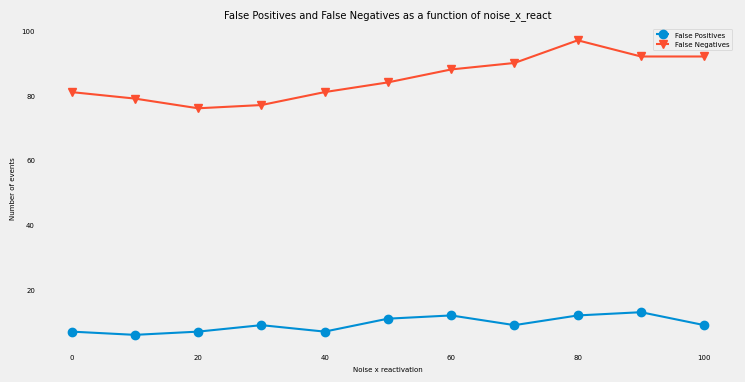

In [25]:
noise_x_reacts = np.linspace(0, 100, 11)
FPs, FNs = np.empty(len(noise_x_reacts)), np.empty(len(noise_x_reacts))

for i, noise_x_react in enumerate(noise_x_reacts):
    FP, FN = get_FP_FN(noise_x_react = noise_x_react)
    FPs[i], FNs[i] = FP, FN

plt.figure(figsize=(8,4))
plt.plot(noise_x_reacts, FPs, 'o-', label='False Positives')
plt.plot(noise_x_reacts, FNs, 'v-', label='False Negatives')
plt.title('False Positives and False Negatives as a function of noise_x_react')
plt.xlabel('Noise x reactivation')
plt.ylabel('Number of events')
plt.legend()
plt.grid()
plt.show()

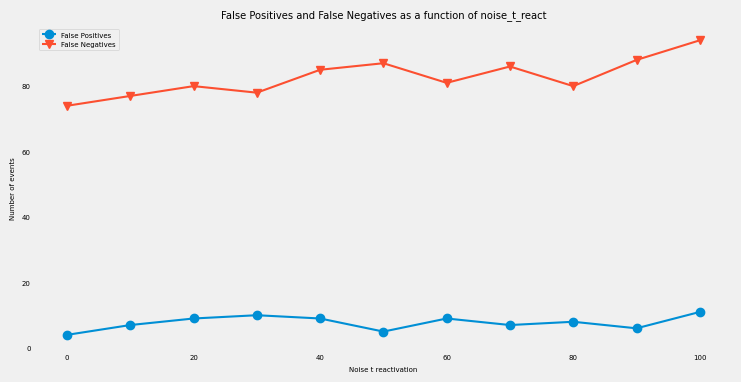

In [26]:
noise_t_reacts = np.linspace(0, 100, 11)
FPs, FNs = np.empty(len(noise_t_reacts)), np.empty(len(noise_t_reacts))

for i, noise_t_react in enumerate(noise_t_reacts):
    FP, FN = get_FP_FN(noise_t_react = noise_t_react)
    FPs[i], FNs[i] = FP, FN

plt.figure(figsize=(8,4))
plt.plot(noise_t_reacts, FPs, 'o-', label='False Positives')
plt.plot(noise_t_reacts, FNs, 'v-', label='False Negatives')
plt.title('False Positives and False Negatives as a function of noise_t_react')
plt.xlabel('Noise t reactivation')
plt.ylabel('Number of events')
plt.legend()
plt.grid()
plt.show()

(B) While the number of False Negatives increases slightly both for noise in time and spike reactivation, the number of False Positives seems to be largely unaffected and stagnates around the nominal alpha threshold of $\alpha = .05$. 

(C) The algorithm can only detect sequences that fire in the same order as the cells fired on the track since the algorithm tries to fit a line on the cells ordered according to their firing pattern on the track. Any sequences that do not follow this order will not be detected. An algorithm that detects also different firing patterns would need to store patterns in memory that appear once and then check if they appear again. However, due to the stochasticity of neurons, such an algorithm would, similarly as the one used here, also need to account for non-perfect correlations between already seen sequences and new ones. This could for example be done by storing a set of different orders in memory and checking the linear fit, as was done here, for all of these sequences instead of only for the preferred sequence on the track.